# Implementing Simple chatbot using langGraph

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

Annotated:

It annotates the message like the HumanMessage and AIMessage



add_messages:

Merges two lists of messages, updating existing messages by ID.

By default, this ensures the state is "append-only", unless the new message has the same ID as an existing message.

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages] # {messages: [_, _, _, _,.... ]}


In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [7]:
from langchain_groq import ChatGroq

LLM = ChatGroq(model="llama-3.1-8b-instant")
LLM.invoke("hello")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010835123, 'prompt_time': 0.001587567, 'queue_time': 0.045437493, 'total_time': 0.01242269}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--617df67b-e0d3-4da2-a41d-fd782e3a09c6-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

# Creating Nodes

In [8]:
def superBot(state: State):
    return {"messages": [LLM.invoke(state['messages'])]}


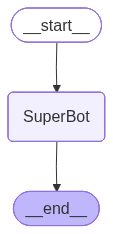

In [9]:
from IPython.display import Image,display

graph = StateGraph(State)

# adding nodes
graph.add_node('SuperBot', superBot)

# adding edges
graph.add_edge(START, 'SuperBot')
graph.add_edge("SuperBot", END)

graph_builder = graph.compile()

# Displaying
display(Image(graph_builder.get_graph().draw_mermaid_png()))

## Execution

### Invocation

In [10]:
# Invocation

graph_builder.invoke({"messages": "Hi, my name is Boon sai and I like anime"})

{'messages': [HumanMessage(content='Hi, my name is Boon sai and I like anime', additional_kwargs={}, response_metadata={}, id='0e285351-e3be-4efd-a662-101cd9fb998f'),
  AIMessage(content="Nice to meet you, Boon sai! It's great to hear that you like anime. There are countless amazing anime shows out there, and I'd be happy to chat with you about your favorite ones or help you discover new ones.\n\nWhat kind of anime do you enjoy? Are you into action-packed series, romantic comedies, or perhaps something a bit more psychological?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 47, 'total_tokens': 123, 'completion_time': 0.104207997, 'prompt_time': 0.002241184, 'queue_time': 0.044520736, 'total_time': 0.106449181}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bbdebaba-6167-4dab-9048-f820ca86a9db-0', usage_metadata={'input_to

### Streaming the responses

In [11]:
graph_builder.stream({'messages':'Hello my name is Boon sai'})

<generator object Pregel.stream at 0x11cce70c0>

In [12]:
for event in graph_builder.stream({'messages':'Hello my name is Boon sai'}):
    print(event)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Boon Sai. Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 42, 'total_tokens': 67, 'completion_time': 0.027783371, 'prompt_time': 0.00192144, 'queue_time': 0.052745289, 'total_time': 0.029704811}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9c3e7b9c-251f-4f5a-b185-e37975e6be21-0', usage_metadata={'input_tokens': 42, 'output_tokens': 25, 'total_tokens': 67})]}}


In [ ]:
# To get human message and as well as AI message, we need to add a parameter 'stream_mode'

# default stream_mode=update - it stores the recently added message only

for event in graph_builder.stream({'messages':'Hello my name is Boon sai'}, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Hello my name is Boon sai', additional_kwargs={}, response_metadata={}, id='c33e02d1-fb7a-4937-b3c4-51f3ddc21ccc')]}
{'messages': [HumanMessage(content='Hello my name is Boon sai', additional_kwargs={}, response_metadata={}, id='c33e02d1-fb7a-4937-b3c4-51f3ddc21ccc'), AIMessage(content='Nice to meet you, Boon Sai. Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 42, 'total_tokens': 67, 'completion_time': 0.028668822, 'prompt_time': 0.002276936, 'queue_time': 0.416231003, 'total_time': 0.030945758}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a7a2f9abbf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0b3806fe-1725-43eb-9f93-b385e53718a0-0', usage_metadata={'input_tokens': 42, 'output_tokens': 25, 'total_tokens': 67})]}


Invocation (invoke)

- Sends input to the model and waits until the entire response is generated.

- Returns a single, complete response at once.

- Simple to use and handle, ideal for short or final results.

- Not suitable for real-time display of long responses, as it blocks until finished.

Streaming (stream)

- Sends input to the model and receives partial outputs as they are generated.

- Returns multiple events or chunks of the response over time.

- Can display real-time output, making it useful for long responses or typing effects.

- Slightly more complex to handle, as you need to process multiple events.

- Supports stream_mode="update" for the latest message and stream_mode="values" for both human and AI messages.

Summary:

invoke gives the full response at once, while stream provides incremental outputs as the model generates them.